In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
import seaborn as sn
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pylab as pl
%matplotlib inline

import os 
import hedfpy

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

In [3]:
os.chdir('../../experiments/ST/')
# input file name
edf_file = os.path.expanduser('~/shared/data/ST/tk_1_2017-10-17_17.10.44.edf')


low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'ST_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + '.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile(os.path.splitext(edf_file)[0] + '.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)


## load the data from the hdf5 file.

We'll print some of the outputs just to show you what's contained in the file

In [4]:
parameters = ho.read_session_data(alias, 'parameters')
parameters.head(10)

,distractor_deviation_angle,distractor_direction,distractor_x,distractor_y,fix_x,fix_y,fixation_time,max_eccentricity,n_trials,saccade_amplitude,saccade_direction,size_distractor_deg,size_fixation_deg,target_distractor_time,target_post_time,target_time,trial_nr
0,30.0,0.000000,0.000000,0.000000,0.000000,0.000000,30.00,12.0,240.0,7.0,0.000000,0.5,0.25,0.05,0.5,0.05,0.0
1,30.0,0.000000,163.260039,-175.068791,163.260039,-175.068791,0.75,12.0,240.0,7.0,2.391084,0.5,0.25,0.05,0.5,0.05,1.0
2,30.0,-0.523599,310.203089,13.903859,385.002778,-84.885200,0.75,12.0,240.0,7.0,1.184524,0.5,0.25,0.05,0.5,0.05,2.0
3,30.0,0.523599,184.126806,45.313748,145.939609,-72.567590,0.75,12.0,240.0,7.0,4.763868,0.5,0.25,0.05,0.5,0.05,3.0
4,30.0,0.523599,233.604542,-295.318082,333.234914,-221.642708,0.75,12.0,240.0,7.0,2.243054,0.5,0.25,0.05,0.5,0.05,4.0
5,30.0,-0.523599,123.617262,-106.042700,209.500706,-16.721338,0.75,12.0,240.0,7.0,5.739967,0.5,0.25,0.05,0.5,0.05,5.0
6,30.0,0.523599,152.409042,215.751164,43.821624,156.059922,0.75,12.0,240.0,7.0,5.518768,0.5,0.25,0.05,0.5,0.05,6.0
7,30.0,0.000000,262.828400,252.698186,262.828400,252.698186,0.75,12.0,240.0,7.0,1.155237,0.5,0.25,0.05,0.5,0.05,7.0
8,30.0,0.000000,38.242387,335.547718,38.242387,335.547718,0.75,12.0,240.0,7.0,5.065800,0.5,0.25,0.05,0.5,0.05,8.0
9,30.0,-0.523599,-10.182855,101.116666,-120.910629,156.737093,0.75,12.0,240.0,7.0,3.868891,0.5,0.25,0.05,0.5,0.05,9.0


In [5]:
trial_phases = ho.read_session_data(alias, 'trial_phases')
trial_phases.head(10)

,trial_phase_trial,trial_phase_EL_timestamp,trial_phase_index,trial_phase_exp_timestamp
0,0.0,1443157,1.0,53.2
1,0.0,1443205,2.0,53.3
2,0.0,1443256,3.0,53.3
3,1.0,1444555,1.0,54.6
4,1.0,1444610,2.0,54.7
5,1.0,1444660,3.0,54.7
6,2.0,1445960,1.0,56.0
7,2.0,1446010,2.0,56.1
8,2.0,1446073,3.0,56.1
9,3.0,1447360,1.0,57.4


In [6]:
trials = ho.read_session_data(alias, 'trials')
trials.head(10)

,trial_start_EL_timestamp,trial_start_index,trial_start_exp_timestamp,trial_end_EL_timestamp,trial_end_index,trial_end_exp_timestamp
0,1438596.0,0,48.7,1443791.0,0,53.8
1,1443791.0,1,53.8,1445208.0,1,55.3
2,1445208.0,2,55.3,1446609.0,2,56.7
3,1446609.0,3,56.7,1448013.0,3,58.1
4,1448013.0,4,58.1,1449411.0,4,59.5
5,1449411.0,5,59.5,1450783.0,5,60.8
6,1450783.0,6,60.8,1452184.0,6,62.2
7,1452184.0,7,62.2,1453596.0,7,63.6
8,1453597.0,8,63.7,1454979.0,8,65.0
9,1454980.0,9,65.0,1456379.0,9,66.4


In [7]:
screen_dims = ho.screen_dimensions_during_trial(alias=alias,trial_nr=0)
pix_per_degrees = screen_dims[0] / 40.0 # the screen @ this distance is 40 degrees wide.

## First, dividing everything up into trials.

We combine information from the tables with the gaze data.

In [8]:
fixation_jump_times = np.array(trial_phases[trial_phases['trial_phase_index'] == 1]['trial_phase_EL_timestamp'])
trial_end_times = np.array(trials['trial_end_EL_timestamp'])

In [9]:
gaze_till_trial_end = [
    np.array(
#         ho.signal_during_period(alias=alias, requested_eye='L', signal='gaze', time_period=(tp[0],tp[1]+300))
        ho.data_from_time_period(alias=alias, columns=['L_gaze_x_int','L_gaze_y_int'], time_period=(tp[0],tp[1]+300))
            )
                       for tp in zip(fixation_jump_times, trial_end_times)]

#### Rotating the data into a common reference frame.
To put all our saccade traces into a common reference frame, we can use rotation using the dot product of our $x,y$ values and the rotation matrix $\begin{bmatrix}cos(\theta) & -sin(\theta)\\sin(\theta) & cos(\theta)\end{bmatrix}$

such that the resulting data are 

$\begin{bmatrix} x_{rot}\\y_{rot}\end{bmatrix} = \begin{bmatrix}cos(\theta) & -sin(\theta)\\sin(\theta) & cos(\theta)\end{bmatrix} * \begin{bmatrix} x\\y\end{bmatrix}$

In [10]:
# subtract the initial fixation position from all trials
gaze_till_trial_end_nofix = [gaze_till_trial_end[trial]-gaze_till_trial_end[trial][0] 
                             for trial in np.arange(1,len(parameters))]

# invert y direction as the data are upside-down for saccade direction
theta = np.angle(np.diff(parameters.fix_x) + 1j * -np.diff(parameters.fix_y))
# use the saccade direction to create rotation matrices for each trial
rotation_matrices = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

# now, we can rotate
gaze_till_trial_end_nofix_rotated = [
    np.dot(gaze_till_trial_end_nofix[trial], rotation_matrices[...,trial])
        for trial in np.arange(len(gaze_till_trial_end_nofix)-1)]

## plot some single trials to see what's up.

With their fixation mark position and target position depicted by an arrow, plus the saccade path rotated to a common reference frame (from middle [0,0] to the right) plotted in red.

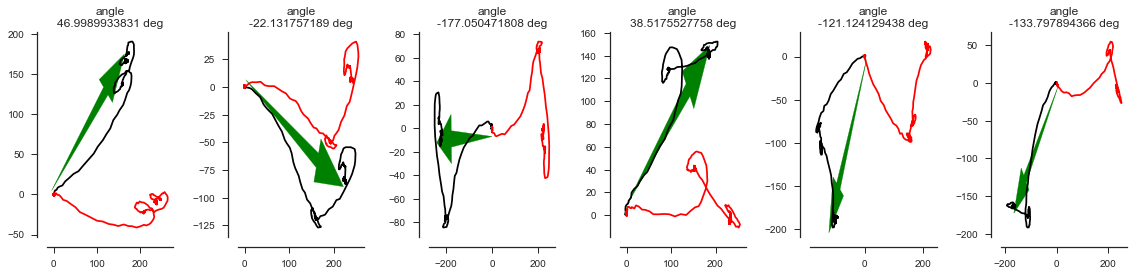

In [11]:
# which trials to plot
which_trials = [0,1,2,3,4,5]
f = pl.figure(figsize = (16,4))
for i, trial in enumerate(which_trials):
    s = f.add_subplot(1,len(which_trials),i+1)
    pl.plot(gaze_till_trial_end_nofix[trial][:,0],gaze_till_trial_end_nofix[trial][:,1], 'k')
    pl.plot(gaze_till_trial_end_nofix_rotated[trial][:,0],gaze_till_trial_end_nofix_rotated[trial][:,1], 'r')
    s.arrow(0,0,np.diff(parameters.fix_x)[trial],-np.diff(parameters.fix_y)[trial], color='g', width=14, length_includes_head=True)
    s.set_title('angle\n' + str(np.degrees(theta[trial]))+' deg')
    sn.despine(ax=s, offset=10)
pl.tight_layout()

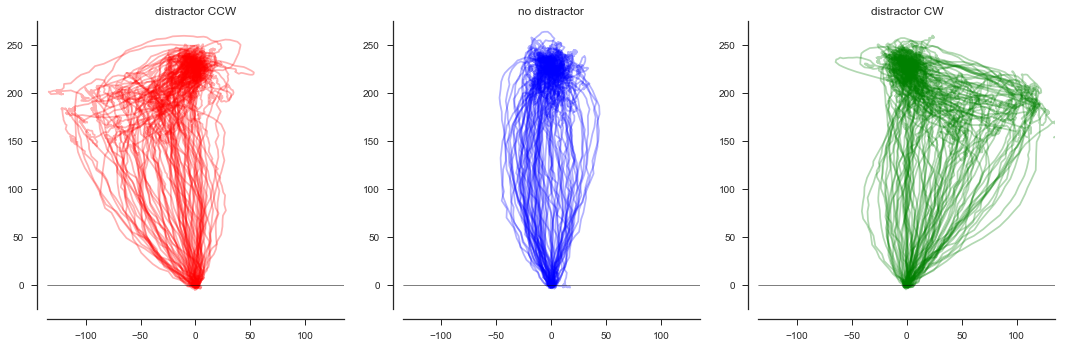

In [12]:
# now plotting these upside-down for the three different conditions in our little experiment
f = pl.figure(figsize = (15,5))
for i, sign_distractor in enumerate([-1,0,1]):
    which_trials = np.arange(len(gaze_till_trial_end_nofix_rotated))[np.sign(parameters.distractor_direction)[1:-1] == sign_distractor]
    s = f.add_subplot(1,3,i+1)
    for wt in which_trials:
        pl.plot(gaze_till_trial_end_nofix_rotated[wt][:,1],
                gaze_till_trial_end_nofix_rotated[wt][:,0], ['r','b','g'][i], alpha=0.3)
    s.set_ylim([-25,275])
    s.set_xlim([-135,135])
    s.axhline(y=0,c='k',lw=0.5)
    s.set_title(['distractor CCW','no distractor','distractor CW'][i])
    sn.despine(ax=s, offset=10)
pl.tight_layout()

### Does the amount of distraction depend on distractor presentation time relative to the onset of the saccade?
First, we look at reaction times, defined as the time of onset of the saccade. 

In [13]:
saccades = []
reaction_times = []
for xy_data in gaze_till_trial_end_nofix_rotated:
    saccs = detect_saccade_from_data(xy_data=xy_data, 
                                        l=5, 
                                        minimum_saccade_duration=0.025)
    saccades.append(saccs)
    reaction_times.append(saccs[0]['expanded_start_time'])
reaction_times = np.array(reaction_times)

In [14]:
# boolean arrays for selection
valid_reaction_time_trials = reaction_times > 60
distractor_trials = np.sign(parameters.distractor_direction)[1:-1] != 0

In [15]:
# normalize reaction times for later plotting
vrts = reaction_times[valid_reaction_time_trials]
min_vrts = np.min(np.log(vrts))
scale_vrts = np.max(np.log(vrts))-np.min(np.log(vrts))

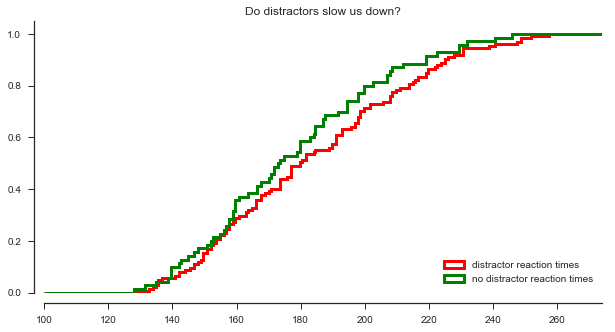

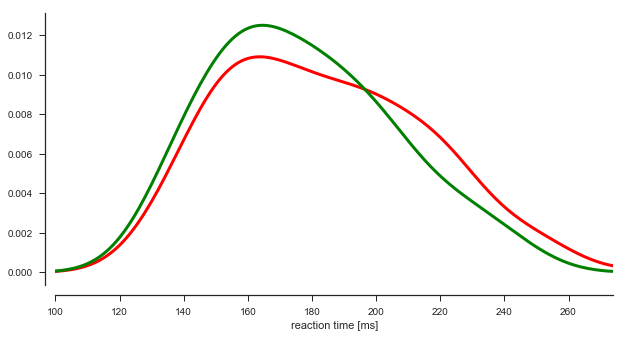

In [16]:
f = pl.figure(figsize = (10,5))
s = f.add_subplot(111)
# pl.hist(reaction_times[valid_reaction_time_trials], 
#         bins=150, 
#         histtype='step', 
#         color='k', 
#         lw=3, 
#         cumulative=True, 
#         normed=True,
#         range=[100,275], label='all reaction times')
pl.hist(reaction_times[valid_reaction_time_trials*distractor_trials], 
        bins=300, 
        histtype='step', 
        color='r', 
        lw=3, 
        cumulative=True, 
        normed=True,
        range=[100,275], label='distractor reaction times')
pl.hist(reaction_times[valid_reaction_time_trials*-distractor_trials], 
        bins=300, 
        histtype='step', 
        color='g', 
        lw=3, 
        cumulative=True, 
        normed=True,
        range=[100,275], label='no distractor reaction times')
s.set_xlim([100,274])
s.set_title('Do distractors slow us down?')
# s.set_xlabel('reaction time [ms]')
pl.legend(loc=4)
sn.despine(fig=f, offset=10)



# and another method of showing more-or-less the same thing, with a kernel density estimate
dist_kde = gaussian_kde(reaction_times[valid_reaction_time_trials*distractor_trials])
dist_density = dist_kde.evaluate(np.arange(0,350))
ndist_kde = gaussian_kde(reaction_times[valid_reaction_time_trials*-distractor_trials])
ndist_density = ndist_kde.evaluate(np.arange(0,350))

f = pl.figure(figsize = (10,5))
s = f.add_subplot(111)
pl.plot(dist_density, 'r', lw=3)
pl.plot(ndist_density, 'g', lw=3)
s.set_xlim([100,274])
# s.set_title('Do distractors slow us down?')
s.set_xlabel('reaction time [ms]')
pl.legend(loc=4)
sn.despine(fig=f, offset=10)

**Do they?**


### Now, we can start plotting trajectories as a function of reaction time...

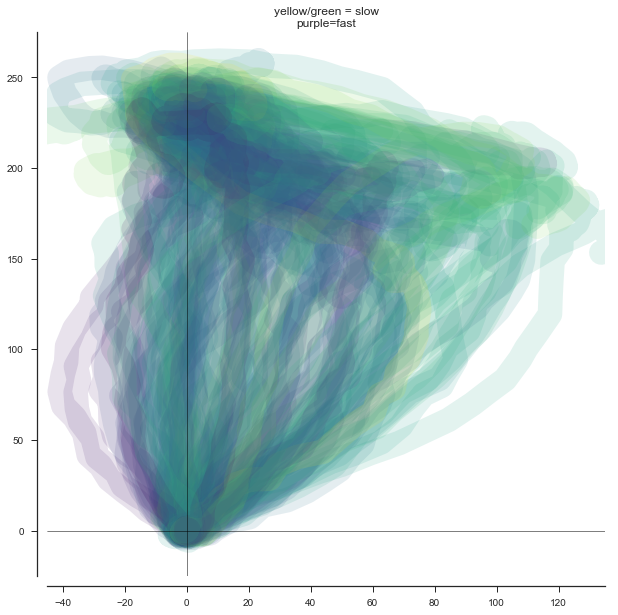

In [17]:
# create a continuous colormap
col = pl.cm.viridis((np.log(reaction_times) - min_vrts) / scale_vrts)

f = pl.figure(figsize = (10,10))
s = f.add_subplot(111)
# plotting in a loop over trials with a distractor
for i, pos in enumerate(np.arange(len(gaze_till_trial_end_nofix_rotated))[distractor_trials]):
    if valid_reaction_time_trials[pos]:
        distractor_sign = np.array(np.sign(parameters.distractor_direction[1:-1][distractor_trials]))[i]
        c_value = (reaction_times[pos] - min_vrts) / scale_vrts
        pl.plot(gaze_till_trial_end_nofix_rotated[pos][:,1] * distractor_sign,
                gaze_till_trial_end_nofix_rotated[pos][:,0], 
                c=col[pos], 
                alpha=0.125, 
                lw=24.5)
s.set_ylim([-25,275])
s.set_xlim([-45,135])
s.axhline(y=0,c='k',lw=0.5)
s.axvline(x=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)
s.set_title('yellow/green = slow\npurple=fast');

### Finally, we can plot trajectories as a function of or saccade angle...

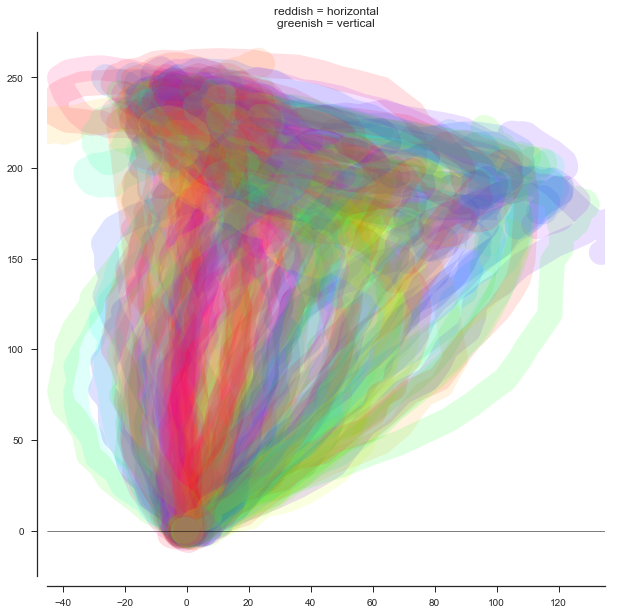

In [18]:
# create a color-wheel colormap based on meridians
col = pl.cm.hsv(np.abs(np.abs(theta)-(np.pi/2))*(np.pi/4))

f = pl.figure(figsize = (10,10))
s = f.add_subplot(111)
# plotting in a loop over trials with a distractor
for i, pos in enumerate(np.arange(len(gaze_till_trial_end_nofix_rotated))[distractor_trials]):
    if valid_reaction_time_trials[pos]:
        distractor_sign = np.array(np.sign(parameters.distractor_direction[1:-1][distractor_trials]))[i]
        pl.plot(gaze_till_trial_end_nofix_rotated[pos][:,1] * distractor_sign,
                gaze_till_trial_end_nofix_rotated[pos][:,0], 
                c=col[pos],
                alpha=0.125, 
                lw=25)
s.set_ylim([-25,275])
s.set_xlim([-45,135])
s.axhline(y=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)
s.set_title('reddish = horizontal\ngreenish = vertical');

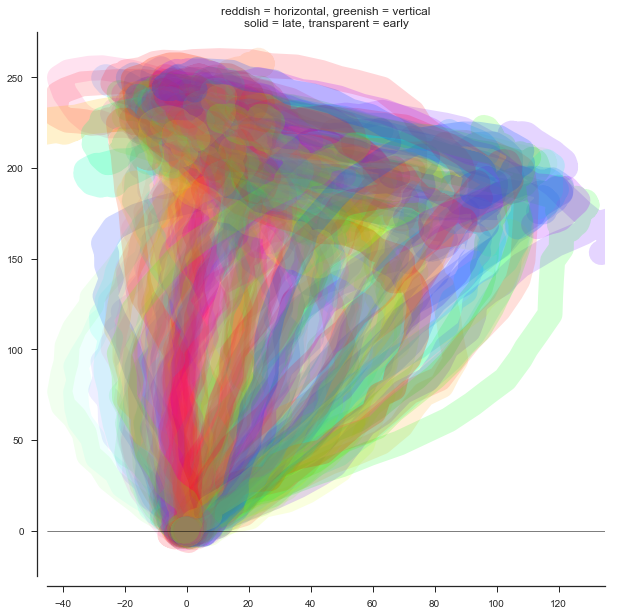

In [19]:
# create a color-wheel colormap based on meridians
col = pl.cm.hsv(np.abs(np.abs(theta)-(np.pi/2))*(np.pi/4))

f = pl.figure(figsize = (10,10))
s = f.add_subplot(111)
# plotting in a loop over trials with a distractor
for i, pos in enumerate(np.arange(len(gaze_till_trial_end_nofix_rotated))[distractor_trials]):
    if valid_reaction_time_trials[pos]:
        distractor_sign = np.array(np.sign(parameters.distractor_direction[1:-1][distractor_trials]))[i]
        pl.plot(gaze_till_trial_end_nofix_rotated[pos][:,1] * distractor_sign,
                gaze_till_trial_end_nofix_rotated[pos][:,0], 
                c=col[pos],
                alpha=0.05 + 0.2 * (np.log(reaction_times[pos]) - min_vrts) / scale_vrts, 
                lw=25)
s.set_ylim([-25,275])
s.set_xlim([-45,135])
s.axhline(y=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)
s.set_title('reddish = horizontal, greenish = vertical\nsolid = late, transparent = early');

**Try to interpret what we've plotted here. Can you think of a way to make the insights you have more explicit?**

## Looking at saccade departure angle and curvature

Let's start to have a look at saccade departure angle, i.e. the direction when the saccade starts. We'll need the reaction time to find the start of the saccade, and then find the angle of the velocity in 2D. 

For the curvature, we'll look at how much extra distance the gaze traveled relative to the straightest possible path; i.e. the *normalized saccade path line integral*.

In [159]:
# some parameters for this analysis:
adi = [3,10] # from 4 to 24 ms from saccade onset is when we take the direction

# array to take the data
directions_curvatures_etc = np.zeros((distractor_trials.sum(), 8))
# a loop over trials with a distractor
for i, pos in enumerate(np.arange(len(gaze_till_trial_end_nofix_rotated))[distractor_trials]):
    if valid_reaction_time_trials[pos]:
        distractor_sign = np.array(np.sign(parameters.distractor_direction[1:-1][distractor_trials]))[i]
        
    #
    #   Calculate the angle the saccade makes
    #
        mirrored_gaze = gaze_till_trial_end_nofix_rotated[pos] * np.array([1,distractor_sign])
        mirrored_gaze_saccade_onset = mirrored_gaze[reaction_times[pos] + adi[1]] - mirrored_gaze[reaction_times[pos] + adi[0]]
        
        saccade_onset_angle = np.angle(mirrored_gaze_saccade_onset[0] + 1j * mirrored_gaze_saccade_onset[1])
    #
    #   Pre-calculated total length of the saccade
    #
        curvature_measure = 0
        if len(saccades[pos]) > 0:
            curvature_measure = saccades[pos][0]['expanded_amplitude'] / \
                        np.linalg.norm(saccades[pos][0]['expanded_vector'])
        peak_y = mirrored_gaze[reaction_times[pos]:,1].max()
                
    #
    #   And, some standard stuff that quantifies saccadic behavior
    #        
        peak_velocity = saccades[pos][0]['peak_velocity']
        amplitude = np.linalg.norm(saccades[pos][0]['expanded_vector'])
        duration = saccades[pos][0]['expanded_duration']
        
        directions_curvatures_etc[i] = [saccade_onset_angle, 
                                        curvature_measure, 
                                        reaction_times[pos], 
                                        theta[pos], 
                                        peak_y,
                                        peak_velocity,
                                        amplitude,
                                        duration]

#### We can plot the results ourselves, which can take a lot of code.

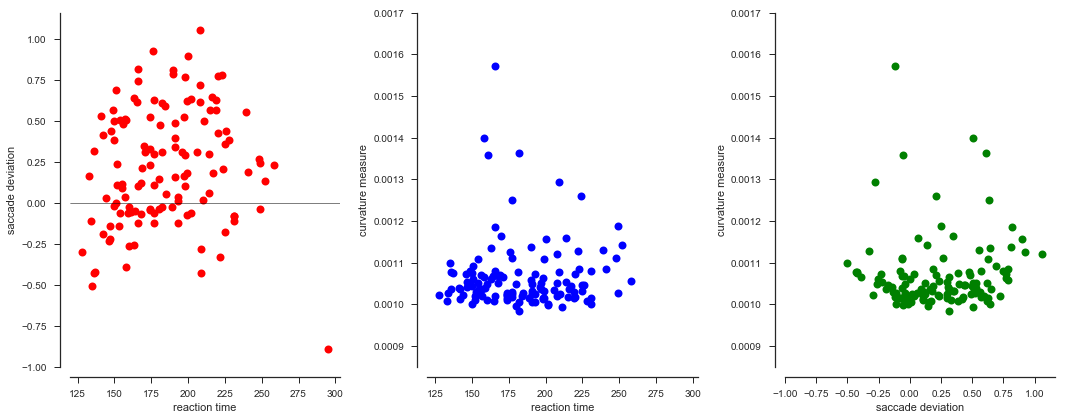

In [160]:
useable_trials = directions_curvatures_etc[:,2] != 0        

col = pl.cm.hsv(np.abs(np.abs(theta)-(np.pi/2))*(np.pi/4))

f = pl.figure(figsize = (15,6))
s = f.add_subplot(131)
pl.scatter( x=directions_curvatures_etc[useable_trials, 2],
            y=directions_curvatures_etc[useable_trials, 0],
            c='r',
            linewidths=2.5,
            s=30
          )
s.set_ylabel('saccade deviation')
s.set_xlabel('reaction time')
s.axhline(y=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)

s = f.add_subplot(132)
pl.scatter( x=directions_curvatures_etc[useable_trials, 2],
            y=directions_curvatures_etc[useable_trials, 1],
            c='b',
            linewidths=2.5,
            s=30
          )
s.set_ylabel('curvature measure')
s.set_xlabel('reaction time')
s.set_ylim([0.00085,0.0017])
# s.axhline(y=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)

s = f.add_subplot(133)
pl.scatter( x=directions_curvatures_etc[useable_trials, 0],
            y=directions_curvatures_etc[useable_trials, 1],
            c='g',
            linewidths=2.5,
            s=30
          )
s.set_ylabel('curvature measure')
s.set_xlabel('saccade deviation')

s.set_ylim([0.00085,0.0017])
# s.axhline(y=0,c='k',lw=0.5)
sn.despine(ax=s, offset=10)

pl.tight_layout()

# s.set_title('reddish = horizontal, greenish = vertical\nsolid = late, transparent = early');

#### Or, we can leave the plotting to seaborn, which provides us with a lot of convenience functions. 

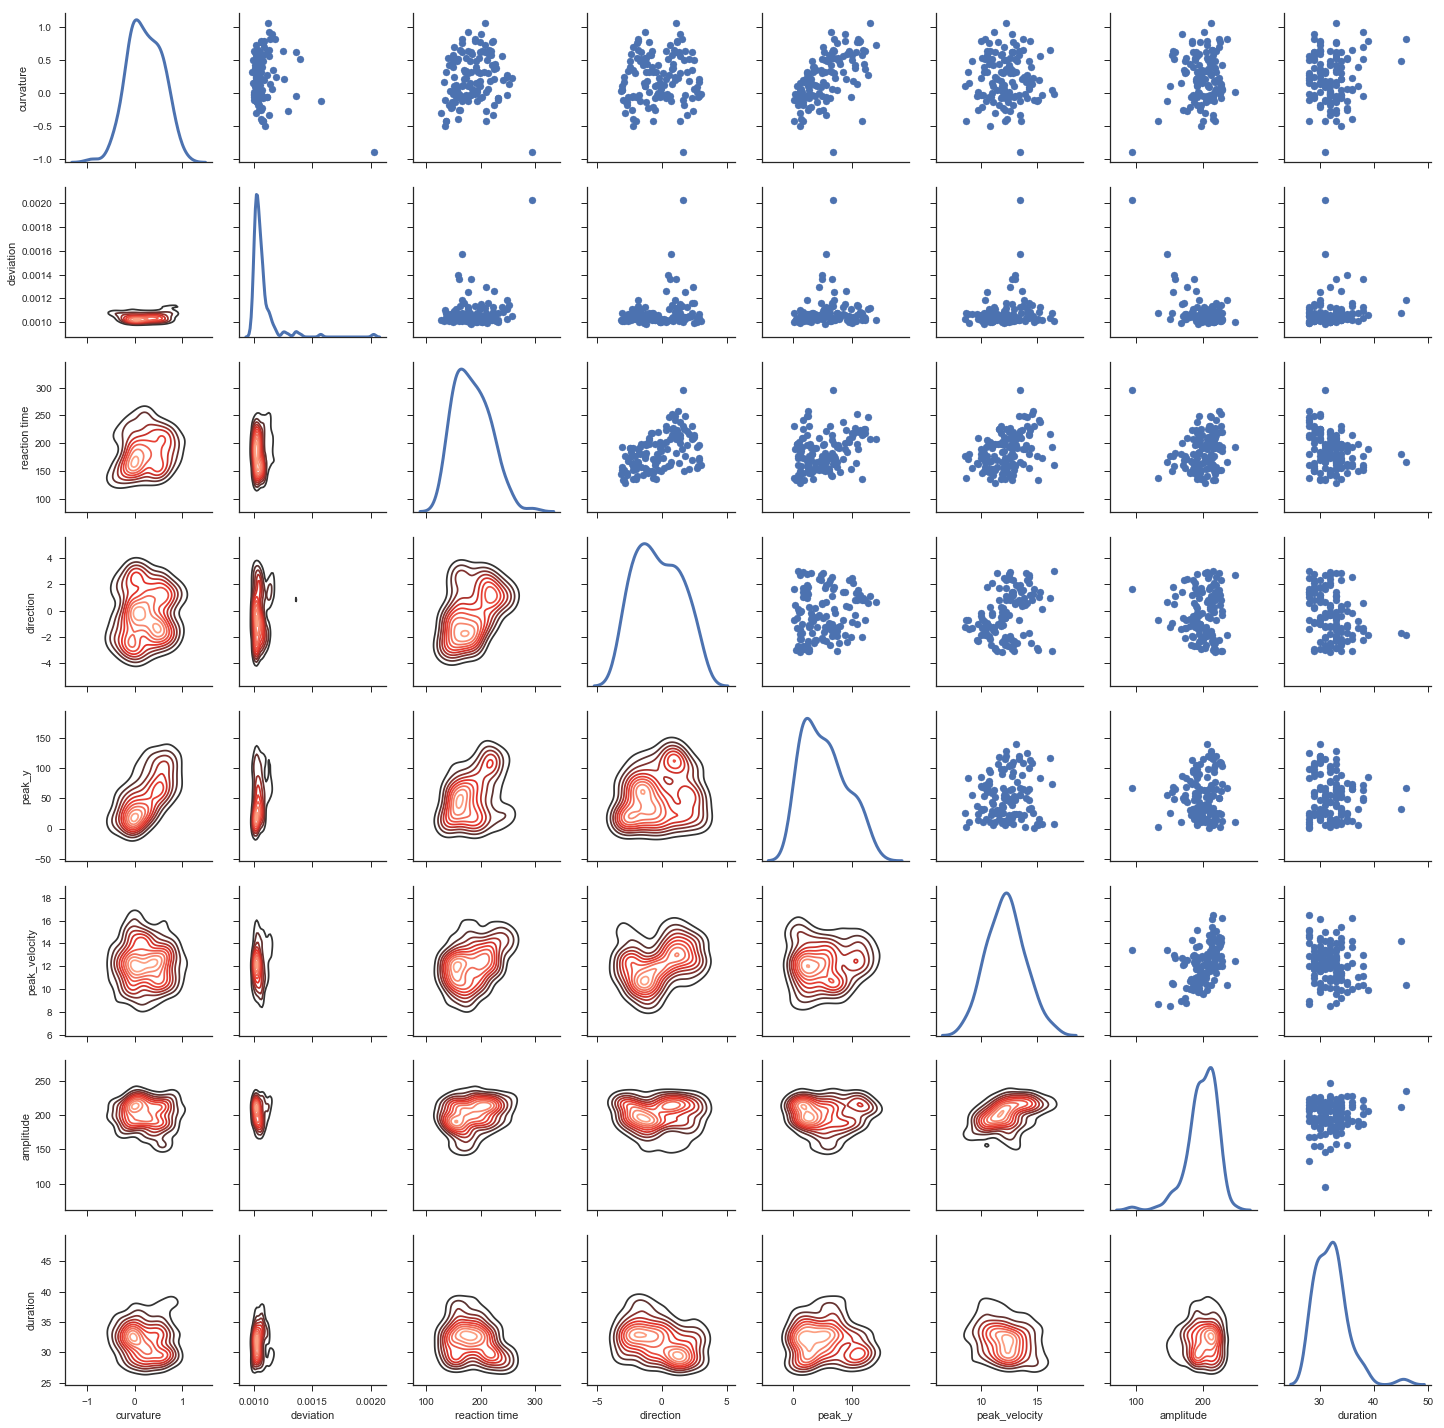

In [161]:
df_columns=['curvature',
                           'deviation',
                           'reaction time',
                           'direction',
                           'peak_y',
                           'peak_velocity',
                           'amplitude',
                           'duration']
df = pd.DataFrame(directions_curvatures_etc[useable_trials], 
                  columns=df_columns)
df.head(10)
g = sn.PairGrid(df, diag_sharey=False, despine=True)
g.map_lower(sn.kdeplot, cmap="Reds_d")
g.map_upper(pl.scatter)
g.map_diag(sn.kdeplot, lw=3)

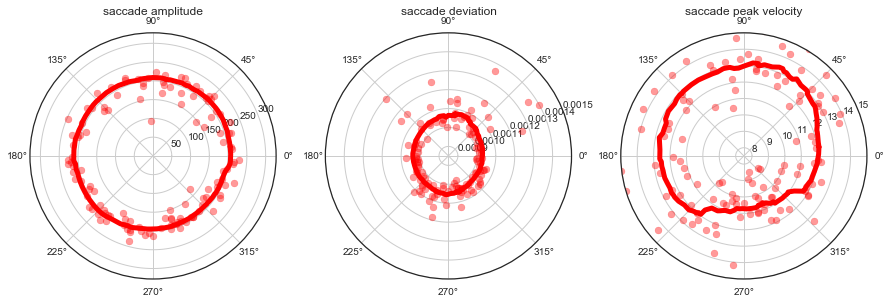

In [162]:
# some parameters
moving_median = 36
mm2 = int(moving_median/2)

# find the original # of trials
original_nr_trials = df.shape[0]
# tile for polar angle smoothing, and smooth using moving median
df_sorted_tiled = pd.DataFrame(
        np.tile(df.sort_values(by='direction', ascending=True).T,3).T,
    columns=df_columns)

# create complex-valued x and y coordinates to smooth
df_sorted_tiled['real_direction'] = np.sin(df_sorted_tiled.direction)
df_sorted_tiled['imag_direction'] = np.cos(df_sorted_tiled.direction)

df_sorted_tiled_smoothed = pd.rolling_median(df_sorted_tiled, 
            moving_median)[original_nr_trials-moving_median:original_nr_trials*2-moving_median+1]

# convert back to directions in angles
df_sorted_tiled_smoothed['smooth_direction'] = np.angle(np.array(df_sorted_tiled_smoothed['imag_direction'] + 1j * df_sorted_tiled_smoothed['real_direction']))

f = pl.figure(figsize = (15,6))
s1 = f.add_subplot(131, projection='polar')
s1.scatter(df.direction, df.amplitude, c='r', alpha=0.4)
s1.plot(df_sorted_tiled_smoothed['smooth_direction'], df_sorted_tiled_smoothed.amplitude, 'r', lw=5)
s1.set_title('saccade amplitude')
s2 = f.add_subplot(132, projection='polar')
s2.scatter(df.direction, df.deviation, c='r', alpha=0.4)
s2.plot(df_sorted_tiled_smoothed['smooth_direction'], df_sorted_tiled_smoothed.deviation, 'r',lw=5)
s2.set_ylim([0.00085,0.0015])
s2.set_title('saccade deviation')
s3 = f.add_subplot(133, projection='polar')
s3.scatter(df.direction, df.peak_velocity, c='r', alpha=0.4)
s3.plot(df_sorted_tiled_smoothed['smooth_direction'], df_sorted_tiled_smoothed.peak_velocity, 'r',lw=5)
s3.set_title('saccade peak velocity')
s3.set_ylim([7.5, 15]);